In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize, root_scalar
from chabochelib import kinematic_hardening, isotropic_hardening, get_sigma_cycle, get_sigma_y, sim_chaboche, format_numbers_dynamic, generate_cycle, sim_chaboche_stress_control
import seaborn as sns

In [23]:
df = pd.read_excel("./data/Projet_I2M_2020-2021.xls")


# Initialize variables for cycle detection
cycle_number = 0
cycle_list = []
found_max = False  # Tracks if we've found the maximum
found_min = False  # Tracks if we've found the minimum

# Calculate the derivative of the strain and fill the first NaN value with 0
df['Strain_Derivative'] = df['Déformation'].diff().fillna(0)

# Iterate over the strain values and their derivatives
for i in range(1, len(df)):  # Start from index 1 to have a valid derivative
    strain_current = df['Déformation'].iloc[i]
    derivative_previous = df['Strain_Derivative'].iloc[i - 1]
    derivative_current = df['Strain_Derivative'].iloc[i]

    # Detect maxima (when derivative changes from positive to negative)
    if derivative_previous > 0 and derivative_current < 0:
        found_max = True

    # Detect minima (when derivative changes from negative to positive)
    if derivative_previous < 0 and derivative_current > 0 and found_max:
        found_min = True

    # Complete the cycle when both a maximum and minimum have been found
    if found_max and found_min and (df['Déformation'].iloc[i-1] * df['Déformation'].iloc[i]) < 0:
        cycle_number += 1
        
        found_max = False  # Reset for the next cycle
        found_min = False  # Reset for the next cycle

    # Append the current cycle number
    cycle_list.append(cycle_number)

# Ensure the first row also gets the initial cycle number
cycle_list = [0] + cycle_list

# Add the cycle list to the DataFrame
df['Cycle'] = cycle_list[:len(df)]  # Ensure the lengths match

df["stress_derivative"] = df["Contrainte (MPa)"].diff()

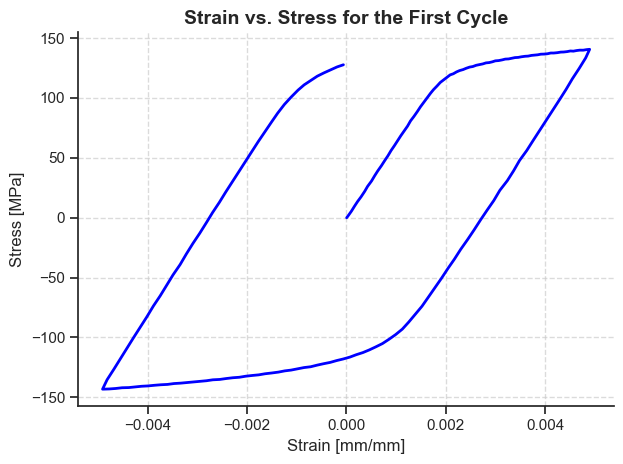

In [24]:
# Apply the Seaborn "ticks" theme
sns.set_theme(style="ticks")

# Create the plot using Matplotlib
plt.plot(df[df["Cycle"] == 0]["Déformation"], df[df["Cycle"] == 0]["Contrainte (MPa)"], color="blue", label='Cycle 0', linewidth=2)

# Customize grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("Strain [mm/mm]", fontsize=12)
plt.ylabel("Stress [MPa]", fontsize=12)
plt.title("Strain vs. Stress for the First Cycle", fontsize=14, weight='bold')
#plt.legend()
plt.tight_layout()

# Remove the top and right spines (ticks theme specific)
sns.despine()

plt.savefig("./fig_report/first_cycle.png", dpi=300)

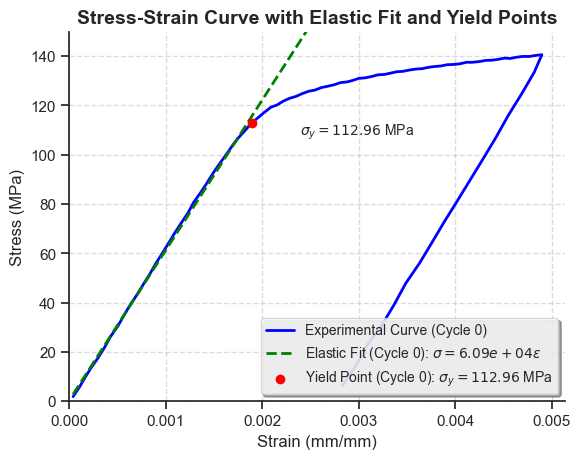

In [25]:
sigma_y, strain_y, deformation, predicted_stress, E, strain_plot, stress_plot = get_sigma_y(
    df[(df["Cycle"] == 0) & (df["Déformation"] > 0) & (df["Contrainte (MPa)"] > 0)]
)

# Apply the Seaborn "ticks" theme
sns.set_theme(style="ticks")

# Plot the experimental stress-strain curve for Cycle 0
plt.plot(
    df[(df["Cycle"] == 0) & (df["Déformation"] > 0) & (df["Contrainte (MPa)"] > 0)]["Déformation"],
    df[(df["Cycle"] == 0) & (df["Déformation"] > 0) & (df["Contrainte (MPa)"] > 0)]["Contrainte (MPa)"],
    label="Experimental Curve (Cycle 0)",
    color="blue",
    linewidth=2
)

# Plot the elastic fit curve
plt.plot(
    strain_plot, stress_plot, 
    label=rf'Elastic Fit (Cycle 0): $\sigma={E:.2e}\varepsilon$', 
    linestyle='--', 
    color="green",
    linewidth=2
)

# Highlight and annotate the first yield point (\sigma_y)
plt.scatter(
    strain_y, sigma_y, 
    color='red', 
    label=rf'Yield Point (Cycle 0): $\sigma_y={sigma_y:.2f}$ MPa',
    zorder=5
)
plt.annotate(
    rf'$\sigma_y={sigma_y:.2f}$ MPa', 
    xy=(strain_y, sigma_y), 
    xytext=(strain_y + 0.0005, sigma_y - 5),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Add labels, title, legend, and grid
plt.xlabel("Strain (mm/mm)", fontsize=12)
plt.ylabel("Stress (MPa)", fontsize=12)
plt.title("Stress-Strain Curve with Elastic Fit and Yield Points", fontsize=14, weight="bold")
plt.legend(fontsize=10, loc='best', frameon=True, fancybox=True, shadow=True, framealpha=0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 150)
plt.xlim(0)

# Remove the top and right spines (ticks theme specific)
sns.despine()

plt.savefig("./fig_report/identification_signa_y.png", dpi=300)

sigma_y0 = sigma_y
strain_y0 = strain_y
epsilon_p0 = df[(df["Cycle"] == 0) & (df["Déformation"] > 0) & (df["Contrainte (MPa)"] > 0)]["Déformation"].max()


In [26]:
# Ensure sigma_y0, strain_y0, cycle_number, df, and E are defined
# List to store yield points
sigma_tab = [
    {
        "Sigma_y": sigma_y0,
        "Strain_y": strain_y0,
        "Cycle": 1,
        "epslilon_p": epsilon_p0 - strain_y0
    }
]

for i in list(range(2, 8)) + list(range(10, cycle_number)):
    plt.figure()

    # Filter the DataFrame for the current and previous cycle
    plotdf = df[
        ((df["Cycle"] == i - 1) & (df["stress_derivative"] > 0) & (df["Déformation"] < 0)) |
        ((df["Cycle"] == i) & (df["stress_derivative"] > 0) & (df["Déformation"] > 0))
    ]

    # Subset data for the elastic fit (example condition: strain < -0.003)
    subset = plotdf[plotdf["Déformation"] < -0.003]

    # Calculate Yield Point and Elastic Fit
    sigma_y, strain_y, intercept = get_sigma_cycle(
        subset["Déformation"],
        subset["Contrainte (MPa)"],
        plotdf["Déformation"],
        plotdf["Contrainte (MPa)"],
        E,
        15
    )

    # Plot the experimental stress-strain curve
    scatter = plt.scatter(
        plotdf["Déformation"],
        plotdf["Contrainte (MPa)"],
        label=f"Experimental Curve (Cycle {i})",
        s=5,
        c=plotdf["Cycle"],
        cmap="viridis"
    )

    # Add a color bar for cycle numbers
    plt.colorbar(scatter, label="Cycle Number")

    # Plot the elastic fit curve
    plt.plot(
        plotdf["Déformation"], E * plotdf["Déformation"] + intercept,
        label=rf'Elastic Fit (Cycle {i}): $\sigma={E:.2e}\varepsilon$',
        linestyle='--'
    )

    # Highlight and annotate the yield point
    plt.scatter(strain_y, sigma_y, color='red', label=rf'Yield Point (Cycle {i}): $\sigma_y={sigma_y:.2f}$ MPa')
    plt.annotate(
        rf'$\sigma_y={sigma_y:.2f}$ MPa',
        xy=(strain_y, sigma_y),
        xytext=(strain_y + 0.0005, sigma_y - 5),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=10
    )

    # Append the yield point data to sigma_tab
    try:
        last_deformation = plotdf["Déformation"].iloc[-1]  # Get the last deformation value safely
        sigma_tab.append(
            {
                "Sigma_y": sigma_y,
                "Strain_y": strain_y,
                "Cycle": i,
                "epslilon_p": last_deformation - strain_y
            }
        )
    except IndexError:
        # Handle cases where `plotdf` is empty
        sigma_tab.append(
            {
                "Sigma_y": sigma_y,
                "Strain_y": strain_y,
                "Cycle": i,
                "epslilon_p": None
            }
        )

    # Add labels, legend, and grid
    plt.xlabel("Strain (mm/mm)")
    plt.ylabel("Stress (MPa)")
    plt.title(f"Stress-Strain Curve with Elastic Fit and Yield Points (Cycle {i})")
    plt.legend()
    plt.grid()

    # Save the plot as a PNG file
    plt.savefig(f"fig/{i}.png")
    plt.close()

# Convert sigma_tab to a DataFrame
sigma_tab = pd.DataFrame(sigma_tab)

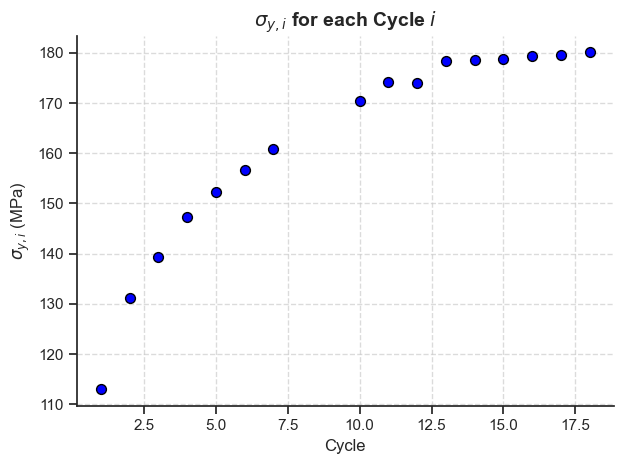

In [27]:
# Apply the Seaborn "ticks" theme
sns.set_theme(style="ticks")

# Scatter plot of Sigma_y vs Cycle
plt.scatter(sigma_tab["Cycle"], sigma_tab["Sigma_y"], color="blue", edgecolor="black", s=50, label="Sigma_y vs Cycle")

# Add labels and title
plt.xlabel("Cycle", fontsize=12)
plt.ylabel(r"$\sigma_{y,i}$ (MPa)", fontsize=12)
plt.title(r"$\sigma_{y,i}$ for each Cycle $i$", fontsize=14, weight="bold")

# Add a grid and adjust spines
sns.despine()
plt.grid(True, linestyle="--", alpha=0.7)

# Add a legend
#plt.legend(fontsize=10)

# Tight layout for better spacing
plt.tight_layout()

# Save the plot if needed
plt.savefig("./fig_report/elasticity_domain_per_cycle.png", dpi=300)

In [28]:
sigma_tab["R"] = sigma_tab["Sigma_y"] - sigma_tab["Sigma_y"][0]
sigma_tab["p"] = sigma_tab["epslilon_p"].cumsum()

In [29]:
# Define weights properly
# Assuming sigma_tab is a dictionary with keys "p" (plastic strain) and "R" (hardening stress)
n_assymp = 4

weights = np.array([1] * (len(sigma_tab["p"]) - n_assymp) + [10] * n_assymp)

# Perform curve fitting with weights
params, covariance = curve_fit(
    isotropic_hardening,
    sigma_tab["p"],
    sigma_tab["R"],
    sigma=1 / weights
)

# Extract fitted parameters
Q_fit, b_fit = params

# Generate data for the fitted curve
p_fit = np.linspace(0, max(sigma_tab["p"]), 100)
R_fit = isotropic_hardening(p_fit, Q_fit, b_fit)

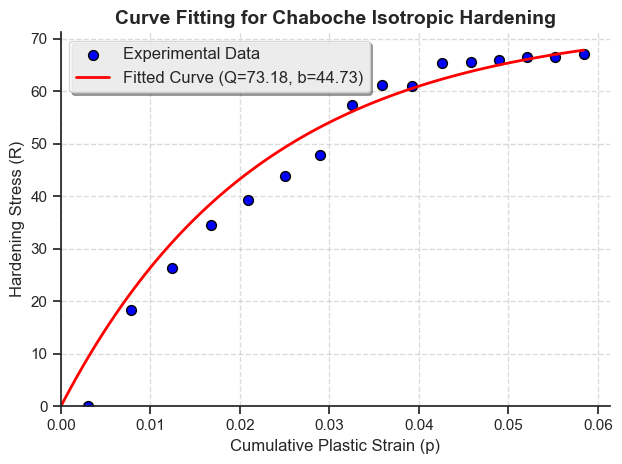

In [30]:
# Apply Seaborn theme
sns.set_theme(style="ticks")

# Create the figure with a defined size
plt.figure()

# Scatter plot of experimental data
plt.scatter(
    sigma_tab["p"], sigma_tab["R"], 
    label='Experimental Data', 
    color='blue', 
    edgecolor='black', 
    s=50  # Size of scatter points
)

# Plot the fitted curve
plt.plot(
    p_fit, R_fit, 
    label=f'Fitted Curve (Q={Q_fit:.2f}, b={b_fit:.2f})', 
    color='red', 
    linewidth=2
)

# Add labels and title with refined font size
plt.xlabel('Cumulative Plastic Strain (p)', fontsize=12)
plt.ylabel('Hardening Stress (R)', fontsize=12)
plt.title('Curve Fitting for Chaboche Isotropic Hardening', fontsize=14, weight="bold")

# Customize the legend
plt.legend(fontsize=12, loc='best', frameon=True, fancybox=True, shadow=True, framealpha=0.8)

# Add a grid with slight alpha for subtlety
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust axis limits
plt.xlim(left=0)
plt.ylim(bottom=0)

# Remove unnecessary spines for a cleaner look
sns.despine()

# Ensure layout doesn't clip labels
plt.tight_layout()

# Save the figure
plt.savefig("./fig_report/chaboche_isotropic_hardening_fit.png", dpi=300)

# Display the plot
plt.show()


In [31]:
# Filter data based on given conditions
data_X = df[(df["Cycle"] == 0) & 
            (df["Déformation"] > 0) & 
            (df["Contrainte (MPa)"] > sigma_y0 - 10) & 
            (df["stress_derivative"] > 0)]

# Define X_kinematic and p_kinematic
X_kinematic = data_X["Contrainte (MPa)"] - (sigma_y0 - 10)
p_kinematic = data_X["Déformation"] - data_X["Déformation"].iloc[0]  # Correct use of iloc

# Perform curve fitting
params2, covariance = curve_fit(
    kinematic_hardening,
    p_kinematic,
    X_kinematic,
    bounds=([0, 0], [np.inf, np.inf])  # Ensure positive gamma and C
)

# Extract fitted parameters
C_fit, gamma_fit = params2

# Generate data for the fitted curve
p_fit = np.linspace(0, max(p_kinematic), 100)
X_fit = kinematic_hardening(p_fit, C_fit, gamma_fit)

# Output the fitted parameters
print(f"Fitted parameters: C = {C_fit:.2f}, γ = {gamma_fit:.2f}")


Fitted parameters: C = 44789.40, γ = 1239.57


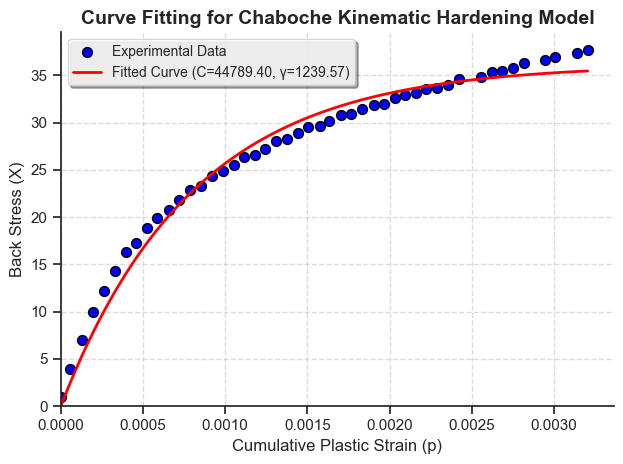

In [32]:
# Apply Seaborn theme for aesthetics
sns.set_theme(style="ticks")

# Create the figure
plt.figure()

# Scatter plot of experimental data
plt.scatter(
    p_kinematic, X_kinematic, 
    label='Experimental Data', 
    color='blue', 
    edgecolor='black', 
    s=50  # Size of scatter points
)

# Plot the fitted curve
plt.plot(
    p_fit, X_fit, 
    label=f'Fitted Curve (C={C_fit:.2f}, γ={gamma_fit:.2f})', 
    color='red', 
    linewidth=2
)

# Add labels and title
plt.xlabel('Cumulative Plastic Strain (p)', fontsize=12)
plt.ylabel('Back Stress (X)', fontsize=12)
plt.title('Curve Fitting for Chaboche Kinematic Hardening Model', fontsize=14, weight='bold')

# Customize legend
plt.legend(fontsize=10, loc='best', frameon=True, fancybox=True, shadow=True, framealpha=0.8)

# Add a grid with subtle styling
plt.grid(True, linestyle='--', alpha=0.7)

# Set axis limits
plt.xlim(left=0)
plt.ylim(bottom=0)

# Remove unnecessary spines (ticks theme)
sns.despine()

# Tight layout for better spacing
plt.tight_layout()

plt.savefig("./fig_report/chaboche_kinematic_hardening_fit.png", dpi=300)

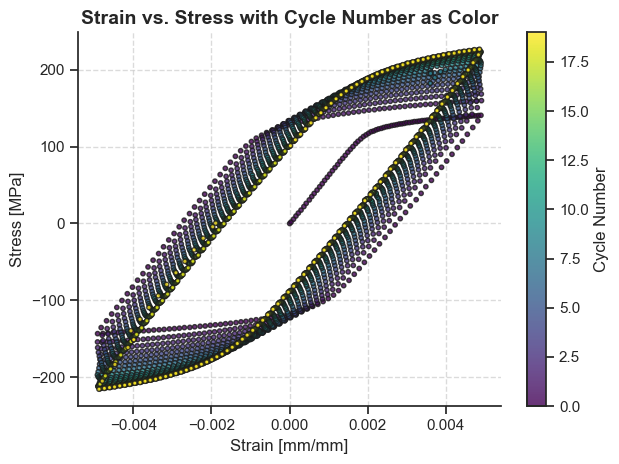

In [33]:
# Apply Seaborn theme for aesthetics
sns.set_theme(style="ticks")

# Create the scatter plot
plt.figure()
scatter = plt.scatter(
    df["Déformation"], 
    df["Contrainte (MPa)"], 
    c=df['Cycle'], 
    cmap='viridis', 
    s=10,  # Adjust size for better visibility
    edgecolor='k',  # Add black edges to points for contrast
    alpha=0.8  # Slight transparency for overlapping points
)

# Add color bar with label
cbar = plt.colorbar(scatter)
cbar.set_label('Cycle Number', fontsize=12)

# Label the axes
plt.xlabel("Strain [mm/mm]", fontsize=12)
plt.ylabel("Stress [MPa]", fontsize=12)

# Set the title
plt.title('Strain vs. Stress with Cycle Number as Color', fontsize=14, weight='bold')

# Add a grid with subtle styling
plt.grid(True, linestyle='--', alpha=0.7)

# Remove unnecessary spines
sns.despine()

# Tight layout for better spacing
plt.tight_layout()

plt.savefig("./fig_report/stress_strain_cycle.png", dpi=300)

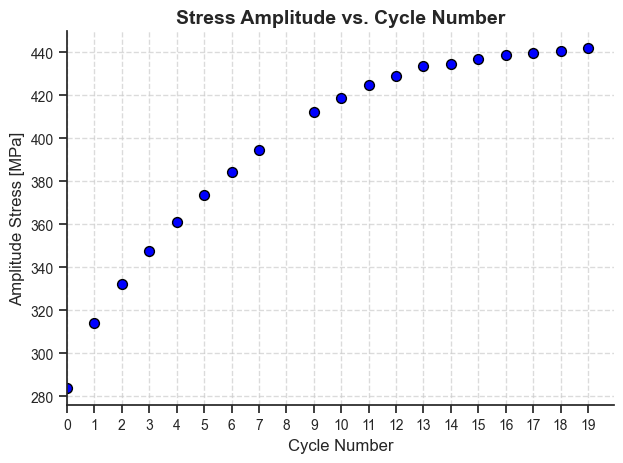

In [34]:
# Apply Seaborn theme
sns.set_theme(style="ticks")

# Prepare the data for plotting
data2plot = []
for cycle in np.unique(df["Cycle"]):
    if cycle != 8:  # Skip cycle 8
        amplitude = df[df["Cycle"] == cycle]["Contrainte (MPa)"].max() - df[df["Cycle"] == cycle]["Contrainte (MPa)"].min()
        data2plot.append([cycle, amplitude])
data2plot = np.array(data2plot)

# Create the plot
plt.figure()
plt.scatter(
    data2plot[:, 0], data2plot[:, 1], 
    label="Stress Amplitude", 
    color="blue",
    edgecolor='black', 
    s=50  # Size of scatter points
)

# Add labels, title, and grid
plt.xlabel("Cycle Number", fontsize=12)
plt.ylabel("Amplitude Stress [MPa]", fontsize=12)
plt.title("Stress Amplitude vs. Cycle Number", fontsize=14, weight="bold")
plt.grid(True, linestyle="--", alpha=0.7)

# Customize ticks
plt.xticks(range(0, int(data2plot[:, 0].max()) + 1, 1), fontsize=10)  # Adjust range for cycles
plt.yticks(fontsize=10)

plt.xlim(0)

# Add a legend
#plt.legend(fontsize=10, loc="best")

# Tight layout for better spacing
plt.tight_layout()

# Remove unnecessary spines
sns.despine()

plt.savefig("./fig_report/stress_amplitude.png", dpi=300)


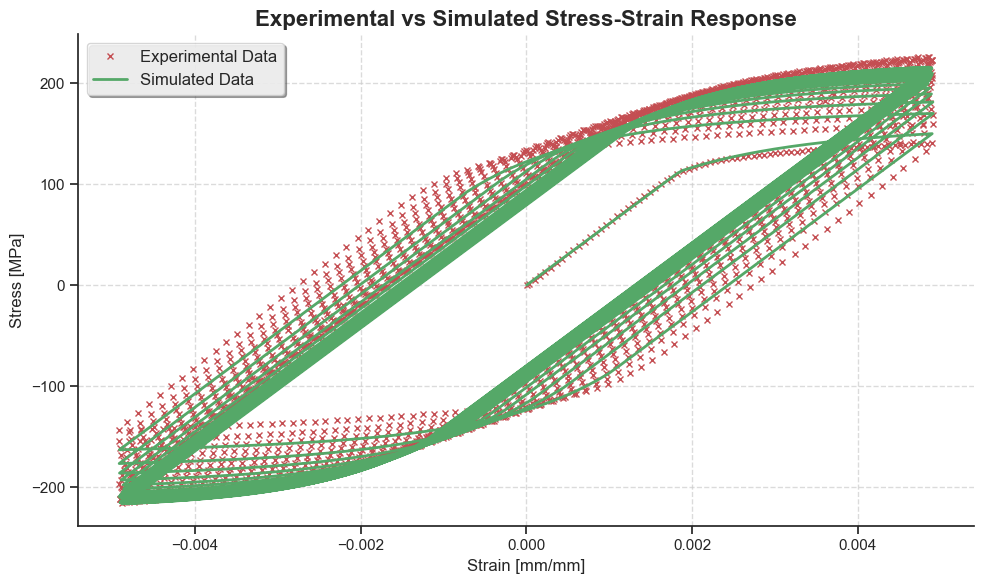

In [35]:
# Apply Seaborn theme
sns.set_theme(style="ticks")

# Filter data and simulate
df2 = df[df["Cycle"] < 20]
sim2 = sim_chaboche(E, sigma_y0, C_fit, gamma_fit, Q_fit, b_fit, df2["Déformation"])

# Create the figure
plt.figure(figsize=(10, 6))

# Plot experimental data
plt.plot(
    df2["Déformation"], 
    df2["Contrainte (MPa)"], 
    'rx', 
    label='Experimental Data', 
    markersize=5
)

# Plot simulated data
plt.plot(
    df2["Déformation"], 
    sim2, 
    'g-', 
    label='Simulated Data', 
    linewidth=2
)

# Customize labels, title, and legend
plt.xlabel('Strain [mm/mm]', fontsize=12)
plt.ylabel('Stress [MPa]', fontsize=12)
plt.title('Experimental vs Simulated Stress-Strain Response', fontsize=16, weight="bold")
plt.legend(fontsize=12, loc='best', frameon=True, fancybox=True, shadow=True, framealpha=0.8)

# Add a grid with subtle styling
plt.grid(True, linestyle="--", alpha=0.7)

# Tight layout for spacing
plt.tight_layout()

sns.despine()

# Save the figure
plt.savefig("./fig_report/simulation_data_experimental.png", dpi=300)

In [36]:
# Objective function
def objective(log_params, strain_exp, stress_exp):
    log_params = np.clip(log_params, -50, 50)  # Prevent exponential overflow
    params = np.exp(log_params)
    E, sigma_y, C, gamma, Q, b = params
    stress_sim = sim_chaboche(E, sigma_y, C, gamma, Q, b, strain_exp)
    error = np.mean((stress_exp - stress_sim) ** 2)  # Mean Squared Error
    return error

# Constraint to restrict sigma_y within ±5% of its initial value
def sigma_y_constraint(log_params):
    params = np.exp(log_params)
    sigma_y = params[1]  # sigma_y is the second parameter
    lower_bound = 0.95 * initial_params[1]
    upper_bound = 1.05 * initial_params[1]
    return np.array([sigma_y - lower_bound, upper_bound - sigma_y])

# Experimental data
# Replace these placeholders with your actual experimental data
strain_exp = df["Déformation"]
stress_exp = df["Contrainte (MPa)"]

# Initial guesses for parameters
initial_params = [E, sigma_y0, C_fit, gamma_fit, Q_fit, b_fit]  # Example guesses for [E, sigma_y, C, gamma, Q, b]
log_initial_params = np.log(initial_params)  # Log-scale initial parameters

# Define constraints
constraints = [{'type': 'ineq', 'fun': sigma_y_constraint}]

# Perform optimization using trust-constr
result = minimize(objective, log_initial_params, args=(strain_exp, stress_exp),
                  method='trust-constr', constraints=constraints,
                  options={'verbose': 1, 'maxiter': 1000})

# Convert optimized parameters back to normal scale
optimized_params = np.exp(result.x)

# Display a comparison table
param_names = ["E", "sigma_y", "C", "gamma", "Q", "b"]
comparison_data = {
    "Parameter": param_names,
    "Initial Value": initial_params,
    "Optimized Value": optimized_params
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

# Simulate using optimized parameters
stress_sim = sim_chaboche(*optimized_params, strain_exp)

C:\Users\louis\OneDrive - INSA de ROUEN Normandie\5.1_MM\Project\.venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 812, function evaluations: 6321, CG iterations: 1950, optimality: 3.32e-01, constraint violation: 0.00e+00, execution time: 4.4e+01 s.
  Parameter  Initial Value  Optimized Value
0         E   60918.471850     63650.594424
1   sigma_y     112.955763       107.365785
2         C   44789.399924     31933.508003
3     gamma    1239.567815       964.192832
4         Q      73.177600        99.549477
5         b      44.734919        14.237690


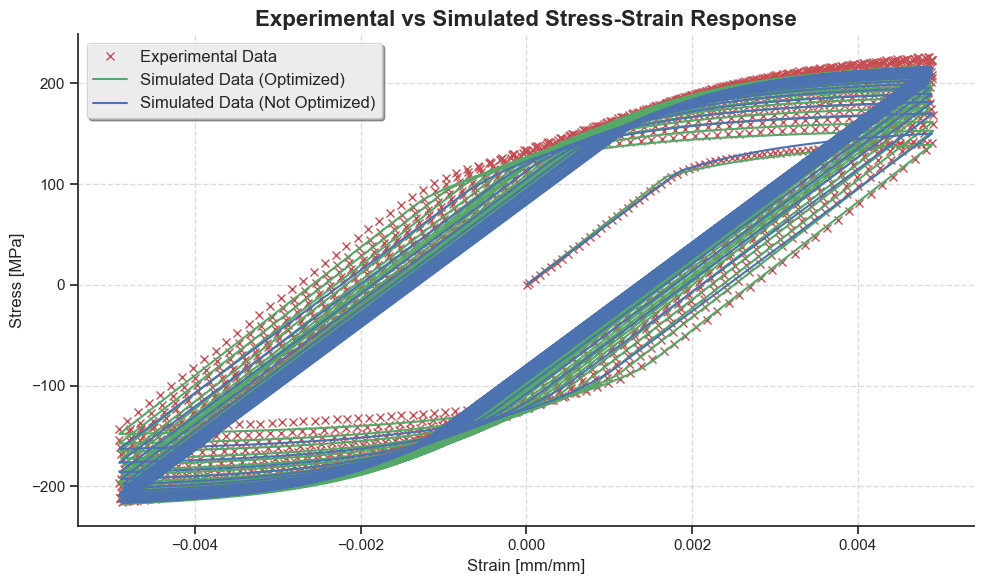

In [37]:

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(strain_exp, stress_exp, 'rx', label='Experimental Data')
plt.plot(strain_exp, stress_sim, 'g-', label='Simulated Data (Optimized)')
plt.plot(strain_exp, sim_chaboche(*initial_params, strain_exp), 'b-', label='Simulated Data (Not Optimized)')
plt.xlabel('Strain [mm/mm]')
plt.ylabel('Stress [MPa]')
plt.title('Experimental vs Simulated Stress-Strain Response', fontsize=16, weight="bold")
plt.grid()

plt.legend(fontsize=12, loc='best', frameon=True, fancybox=True, shadow=True, framealpha=0.8)

# Add a grid with subtle styling
plt.grid(True, linestyle="--", alpha=0.7)

# Tight layout for spacing
plt.tight_layout()

sns.despine()


plt.savefig("./fig_report/simulation_exp_param_fit_all_data_set.png", dpi=300)

In [38]:
# Format the DataFrame
formatted_df = format_numbers_dynamic(comparison_df, 1,500)
print(formatted_df)

# Export to LaTeX
latex_code = formatted_df.to_latex(
    index=False, 
    escape=False, 
    caption="Parameters of the chaboche model before and after optimisation", 
    label="tab:dynamic_formatted_table"
)

# Save to file
with open("./fig_report/table_param_optim.tex", "w") as f:
    f.write(latex_code)

  Parameter Initial Value Optimized Value
0         E      6.09e+04        6.37e+04
1   sigma_y        112.96          107.37
2         C      4.48e+04        3.19e+04
3     gamma      1.24e+03        9.64e+02
4         Q         73.18           99.55
5         b         44.73           14.24


C:\Users\louis\OneDrive - INSA de ROUEN Normandie\5.1_MM\Project\chabochelib.py:196: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(dynamic_format)


In [39]:
# Format the DataFrame
formatted_df = format_numbers_dynamic(sigma_tab, 1,500)
print(formatted_df)

# Export to LaTeX
latex_code = formatted_df.to_latex(
    index=False, 
    escape=False, 
    caption="Formatted Table with Dynamic Number Formatting", 
    label="tab:dynamic_formatted_table"
)

# Save to file
with open("./fig_report/table_R,p.tex", "w") as f:
    f.write(latex_code)

   Sigma_y   Strain_y  Cycle epslilon_p         R         p
0   112.96   1.89e-03   1.00   3.01e-03  0.00e+00  3.01e-03
1   131.22  -4.06e-05   2.00   4.85e-03     18.27  7.85e-03
2   139.23   2.36e-04   3.00   4.58e-03     26.28  1.24e-02
3   147.38   5.16e-04   4.00   4.32e-03     34.42  1.68e-02
4   152.19   6.64e-04   5.00   4.19e-03     39.24  2.09e-02
5   156.73   8.11e-04   6.00   4.06e-03     43.78  2.50e-02
6   160.82   9.57e-04   7.00   3.93e-03     47.86  2.89e-02
7   170.38   1.29e-03  10.00   3.54e-03     57.43  3.25e-02
8   174.10   1.44e-03  11.00   3.41e-03     61.14  3.59e-02
9   174.03   1.46e-03  12.00   3.40e-03     61.07  3.93e-02
10  178.29   1.61e-03  13.00   3.28e-03     65.34  4.26e-02
11  178.54   1.63e-03  14.00   3.27e-03     65.59  4.58e-02
12  178.80   1.64e-03  15.00   3.14e-03     65.84  4.90e-02
13  179.44   1.67e-03  16.00   3.14e-03     66.49  5.21e-02
14  179.51   1.68e-03  17.00   3.15e-03     66.55  5.53e-02
15  180.09   1.70e-03  18.00   3.14e-03 

C:\Users\louis\OneDrive - INSA de ROUEN Normandie\5.1_MM\Project\chabochelib.py:196: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(dynamic_format)


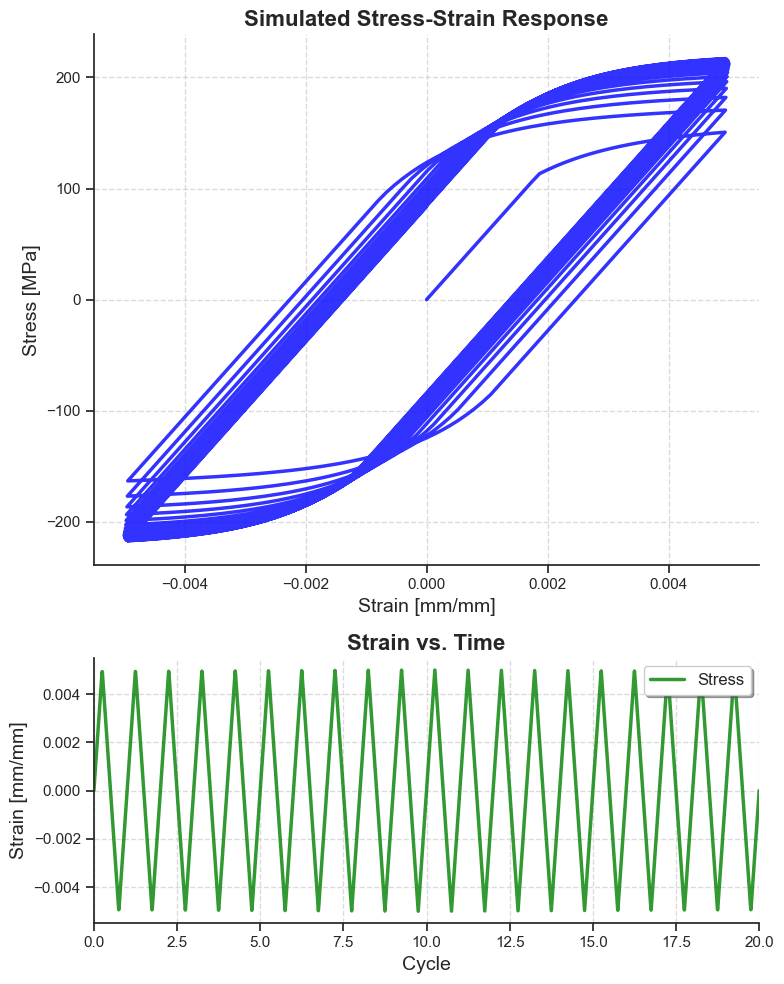

In [40]:
strain_given, t = generate_cycle(20, amplitude=0.01)
stress_sim = sim_chaboche(E, sigma_y0, C_fit, gamma_fit, Q_fit, b_fit, strain_given)

sns.set_theme(style="ticks")

# Create the figure with customized subplot heights
fig, axes = plt.subplots(
    2, 1, figsize=(8, 10),  # Two subplots stacked vertically
    gridspec_kw={'height_ratios': [2, 1]}  # Stress-strain 2/3, Stress-time 1/3
)

# Plot the stress-strain response in the top subplot
axes[0].plot(strain_given, stress_sim, label="Simulated Data", linewidth=2.5, color='blue', alpha=0.8)
axes[0].set_xlabel("Strain [mm/mm]", fontsize=14)
axes[0].set_ylabel("Stress [MPa]", fontsize=14)
axes[0].set_title("Simulated Stress-Strain Response", fontsize=16, weight="bold")
axes[0].grid(visible=True, linestyle="--", alpha=0.7)
#axes[0].legend(fontsize=12, loc="upper left", frameon=True, fancybox=True, shadow=True)
sns.despine(ax=axes[0])

# Plot the stress-time response in the bottom subplot
axes[1].plot(t, strain_given, label="Stress", linewidth=2.5, color='green', alpha=0.8)
#axes[1].plot(t, t*0 + np.mean(strain_given), "--",  label="Average", linewidth=2.5, color='red', alpha=0.8)
#axes[1].text(0.7,  np.mean(strain_given) *1.2, f"{np.mean(strain_given):.2f} MPa", color = "red", fontsize=14,weight="bold")
# Set axis labels and title
axes[1].set_xlabel("Cycle", fontsize=14)
axes[1].set_ylabel("Strain [mm/mm]", fontsize=14)
axes[1].set_title("Strain vs. Time", fontsize=16, weight="bold")
# Add gridlines for better readability
axes[1].grid(visible=True, linestyle="--", alpha=0.7)

# Enhance the legend for better presentation
axes[1].legend(fontsize=12, loc="upper right", frameon=True, fancybox=True, shadow=True)

# Adjust x-axis limits to match the data range
axes[1].set_xlim(0, t.max())

# Use Seaborn's despine for cleaner aesthetics
sns.despine(ax=axes[1])


# Tight layout for better spacing
plt.tight_layout()

plt.savefig("./fig_report/simulated_strain_average0.png", dpi=300)

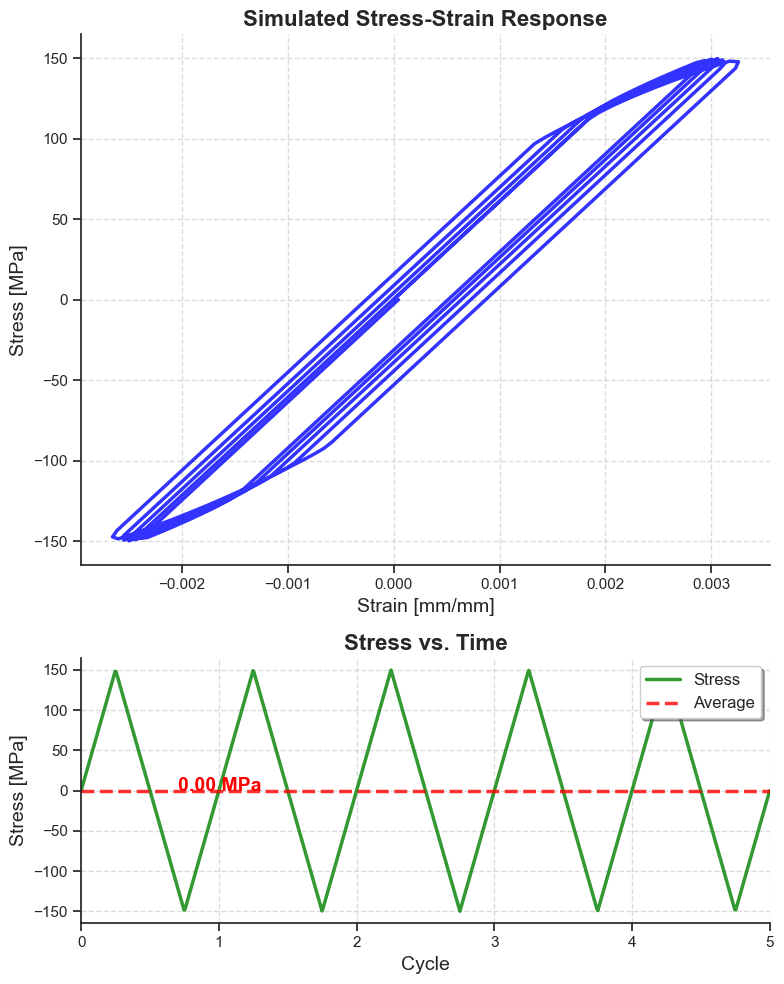

In [41]:
stress_given, t = generate_cycle(5, amplitude=300)
strain_sim = sim_chaboche_stress_control(E, sigma_y0, C_fit, gamma_fit, Q_fit, b_fit, stress_given)

sns.set_theme(style="ticks")

# Create the figure with customized subplot heights
fig, axes = plt.subplots(
    2, 1, figsize=(8, 10),  # Two subplots stacked vertically
    gridspec_kw={'height_ratios': [2, 1]}  # Stress-strain 2/3, Stress-time 1/3
)

# Plot the stress-strain response in the top subplot
axes[0].plot(strain_sim, stress_given, label="Simulated Data", linewidth=2.5, color='blue', alpha=0.8)
axes[0].set_xlabel("Strain [mm/mm]", fontsize=14)
axes[0].set_ylabel("Stress [MPa]", fontsize=14)
axes[0].set_title("Simulated Stress-Strain Response", fontsize=16, weight="bold")
axes[0].grid(visible=True, linestyle="--", alpha=0.7)
#axes[0].legend(fontsize=12, loc="upper left", frameon=True, fancybox=True, shadow=True)
sns.despine(ax=axes[0])

# Plot the stress-time response in the bottom subplot
axes[1].plot(t, stress_given, label="Stress", linewidth=2.5, color='green', alpha=0.8)
axes[1].plot(t, t*0 + np.mean(stress_given), "--",  label="Average", linewidth=2.5, color='red', alpha=0.8)
axes[1].text(0.7,  np.mean(stress_given) *1.2, f"{np.mean(stress_given):.2f} MPa", color = "red", fontsize=14,weight="bold")
# Set axis labels and title
axes[1].set_xlabel("Cycle", fontsize=14)
axes[1].set_ylabel("Stress [MPa]", fontsize=14)
axes[1].set_title("Stress vs. Time", fontsize=16, weight="bold")
# Add gridlines for better readability
axes[1].grid(visible=True, linestyle="--", alpha=0.7)

# Enhance the legend for better presentation
axes[1].legend(
    fontsize=12, loc="upper right", frameon=True, fancybox=True, shadow=True
)

# Adjust x-axis limits to match the data range
axes[1].set_xlim(0, t.max())

# Use Seaborn's despine for cleaner aesthetics
sns.despine(ax=axes[1])


# Tight layout for better spacing
plt.tight_layout()

plt.savefig("./fig_report/simulated_stress_average0MPa.png", dpi=300)

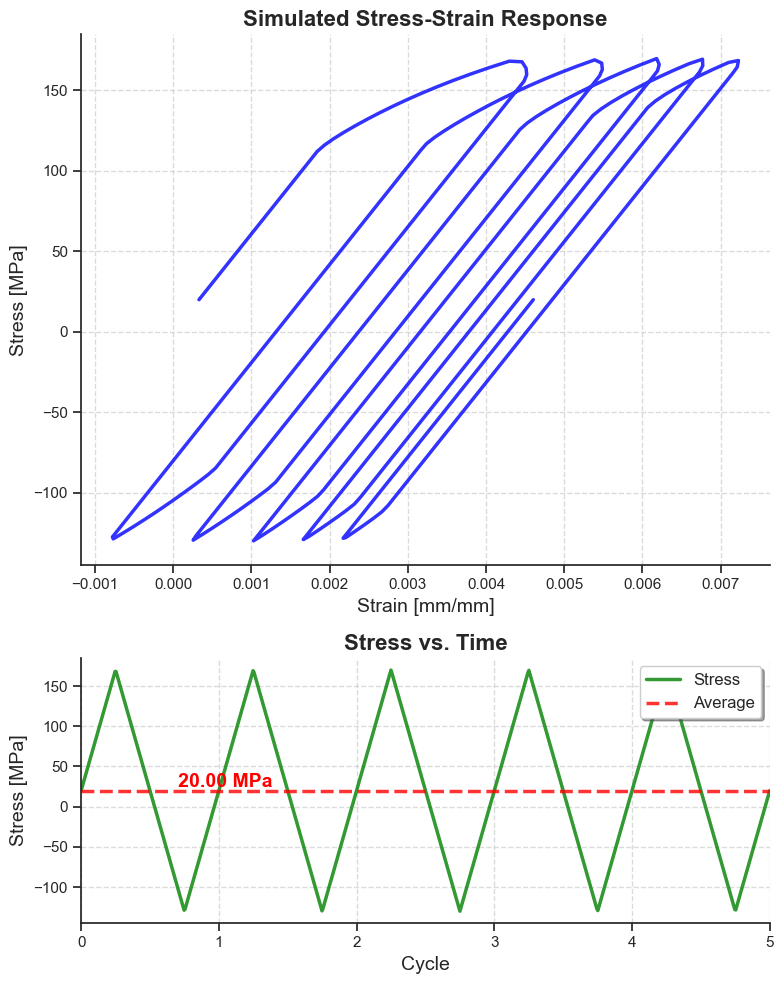

In [42]:
stress_given, t = generate_cycle(5, amplitude=300, average=20)
strain_sim = sim_chaboche_stress_control(E, sigma_y0, C_fit, gamma_fit, Q_fit, b_fit, stress_given)


sns.set_theme(style="ticks")

# Create the figure with customized subplot heights
fig, axes = plt.subplots(
    2, 1, figsize=(8, 10),  # Two subplots stacked vertically
    gridspec_kw={'height_ratios': [2, 1]}  # Stress-strain 2/3, Stress-time 1/3
)

# Plot the stress-strain response in the top subplot
axes[0].plot(strain_sim, stress_given, label="Simulated Data", linewidth=2.5, color='blue', alpha=0.8)
axes[0].set_xlabel("Strain [mm/mm]", fontsize=14)
axes[0].set_ylabel("Stress [MPa]", fontsize=14)
axes[0].set_title("Simulated Stress-Strain Response", fontsize=16, weight="bold")
axes[0].grid(visible=True, linestyle="--", alpha=0.7)
#axes[0].legend(fontsize=12, loc="upper left", frameon=True, fancybox=True, shadow=True)
sns.despine(ax=axes[0])

# Plot the stress-time response in the bottom subplot
axes[1].plot(t, stress_given, label="Stress", linewidth=2.5, color='green', alpha=0.8)
axes[1].plot(t, t*0 + np.mean(stress_given), "--",  label="Average", linewidth=2.5, color='red', alpha=0.8)
axes[1].text(0.7,  np.mean(stress_given) *1.2, f"{np.mean(stress_given):.2f} MPa", color = "red", fontsize=14,weight="bold")
# Set axis labels and title
axes[1].set_xlabel("Cycle", fontsize=14)
axes[1].set_ylabel("Stress [MPa]", fontsize=14)
axes[1].set_title("Stress vs. Time", fontsize=16, weight="bold")
# Add gridlines for better readability
axes[1].grid(visible=True, linestyle="--", alpha=0.7)

# Enhance the legend for better presentation
axes[1].legend(
    fontsize=12, loc="upper right", frameon=True, fancybox=True, shadow=True
)

# Adjust x-axis limits to match the data range
axes[1].set_xlim(0, t.max())

# Use Seaborn's despine for cleaner aesthetics
sns.despine(ax=axes[1])

# Tight layout for better spacing
plt.tight_layout()

plt.savefig("./fig_report/simulated_stress_average20MPa.png", dpi=300)